In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")  # we should remove this at some point soon :)\

### Weighted annual means
Weight by number of days in each month

In [2]:
def month_wts(nyears):
    days_pm  = [31,28,31,30,31,30,31,31,30,31,30,31]
    return xr.DataArray(np.tile(days_pm,nyears),dims='time')

### Point to datasets

In [3]:
path = '/glade/campaign/cgd/tss/wwieder/CMIP6/'
pre  = ['nbp_Lmon_','areacella_fx_','sftlf_fx_']

models = ['ACCESS-ESM1-5','CanESM5','CESM2',
          'CMCC-CM2-SR5','CNRM-ESM2-1','GFDL-ESM4',
          #'GISS-E2-1-H', SSP data from GISS are not correct
          'INM-CM5-0','IPSL-CM6A-LR','MIROC-ES2L',
          'MPI-ESM1-2-LR','UKESM1-0-LL',
         ]

for m in range(len(models)):

    hist = path+'nbp/hist/'  +pre[0]+models[m]+'*.nc'
    ssp  = path+'nbp/ssp370/'+pre[0]+models[m]+'*.nc'
    area = path+'areacella/' +pre[1]+models[m]+'*.nc'
    lfrac= path+'sftlf/'     +pre[2]+models[m]+'*.nc'

    nbp_hist= xr.open_mfdataset(hist, decode_times=True).nbp
    nbp_ssp = xr.open_mfdataset(ssp,  decode_times=True).nbp
    area    = xr.open_mfdataset(area, decode_times=True).areacella
    lfrac   = xr.open_mfdataset(lfrac, decode_times=True).sftlf
    nbp = xr.concat([nbp_hist,nbp_ssp], 'time')
    print('read in model '+models[m])

    nyears = len(np.unique(nbp['time.year']))
    cf  = 24*60*60          # used to convert /s to /d
    dpm = month_wts(nyears) # days per month

    # annual sum
    nbp_amean = cf*(dpm*nbp).groupby('time.year').sum(skipna=True) 
    nbp_amean.attrs['units'] = 'kgC m^-2 y^-1'
    
    # force coords to match
    lfrac['lat'],lfrac['lon'] = area['lat'],area['lon']
    # calculate global sum
    landUp = area * lfrac / 100.  # TODO: check that all sftlf are [0, 100], i.e. expressed in %
    landUp = landUp.where(landUp>0)
    nbp_amean['lat'],nbp_amean['lon'] = landUp['lat'],landUp['lon']
    mean_wgt = nbp_amean * landUp

    ann_glob = mean_wgt.sum(dim=('lat','lon')) * 1e-12  # sum over lat/lon, convert to Pg/y
    ann_glob.attrs['units'] = 'Pg C y^-1'
    ann_glob.name = 'nbp'
    ann_glob.assign_coords({"model": models[m]})
    ann_glob = ann_glob.to_dataset().compute()
    if m == 1 or m==4 or m==7 or m==8 or m==10:
        ann_glob = ann_glob.drop_vars('type')
    
    if m == 0:
        nbp_out = ann_glob
    else:
        nbp_out = xr.combine_nested([nbp_out, ann_glob],concat_dim='model')

nbp_out = nbp_out.drop_vars('type')        

read in model ACCESS-ESM1-5
read in model CanESM5
read in model CESM2
read in model CMCC-CM2-SR5
read in model CNRM-ESM2-1
read in model GFDL-ESM4
read in model INM-CM5-0
read in model IPSL-CM6A-LR
read in model MIROC-ES2L
read in model MPI-ESM1-2-LR
read in model UKESM1-0-LL


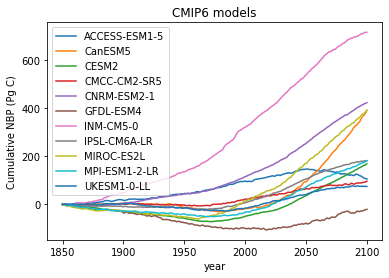

In [15]:
#for m in range(len(models)):
nbp_out.nbp.cumsum(dim='year').plot(hue='model',label=models) ;
plt.legend()  
plt.ylabel('Cumulative NBP (Pg C)')
plt.title('CMIP6 models') ;

Text(0.5, 1.0, 'CMIP6 models')

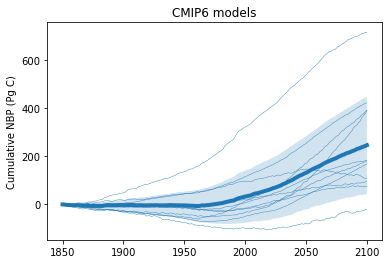

In [30]:
x = nbp_out.year
y = nbp_out.nbp.cumsum(dim='year').mean('model')
y2 = nbp_out.nbp.cumsum(dim='year').std('model')
plt.plot(x,y,linewidth=4)
plt.fill_between(x,y+y2,y-y2, alpha=0.2) 
for m in range(len(models)):
    plt.plot(x,nbp_out.nbp.isel(model=m).cumsum(dim='year').values,
             linewidth=0.4, color='tab:blue')
plt.ylabel('Cumulative NBP (Pg C)')
plt.title('CMIP6 models')  ;

In [32]:
path = '/glade/campaign/cgd/tss/wwieder/CMIP6/'
path2 = '/glade/scratch/wwieder/'
# ---- write out file ----
fout = path2 + 'CMIP6_annual_nbp' + '.nc'
nbp_out.to_netcdf(fout, format='NETCDF4_CLASSIC',unlimited_dims='year')
print('wrote '+fout)

wrote /glade/scratch/wwieder/CMIP6_annual_nbp.nc


In [276]:
nbp_out.to_pandas()

,ACCESS-ESM1-5,CanESM5,CESM2,CMCC-CM2-SR5,CNRM-ESM2-1,GFDL-ESM4,INM-CM5-0,IPSL-CM6A-LR,MIROC-ES2L,MPI-ESM1-2-LR,UKESM1-0-LL
year,,,,,,,,,,,
1850,-0.921215,-2.574424,-0.260032,-0.986493,-0.222045,-2.572085,0.548201,0.100932,-0.756888,1.248262,0.986927
1851,0.302985,0.197438,0.134010,0.204134,-0.612160,2.171377,-1.184705,-0.755947,-2.538657,-0.666108,-0.335995
1852,1.162707,0.549981,-0.834437,1.267038,-0.483875,-1.251051,-0.626811,-0.836019,-1.580601,-1.200851,-0.463331
1853,0.303823,-2.200084,-0.345473,-1.131724,0.540941,-3.585646,-0.254762,-0.576599,-0.570080,-3.273170,-0.813067
1854,-1.149615,-0.645280,-0.354651,-0.648780,-0.865048,-0.436192,-1.805220,-0.141335,-0.239738,-1.877898,-0.419503
...,...,...,...,...,...,...,...,...,...,...,...
2096,-3.014973,10.152779,3.386711,1.118609,2.201222,-1.106480,2.675057,0.396597,6.170234,2.695011,1.542414
2097,-3.917924,5.848365,2.717304,1.863244,2.495806,2.397980,-0.471655,-0.264890,1.254946,0.187723,-1.608096
2098,-2.442761,6.134706,2.233228,0.186923,3.428200,1.629846,3.619813,1.998399,3.903499,2.464437,0.403433


read in model ACCESS-ESM1-5
read in model CanESM5
read in model CESM2
read in model CMCC-CM2-SR5
read in model CNRM-ESM2-1
read in model GFDL-ESM4
read in model INM-CM5-0
read in model IPSL-CM6A-LR
read in model MIROC-ES2L
read in model MPI-ESM1-2-LR
read in model UKESM1-0-LL


In [284]:
nbp_out

<xarray.Dataset>
Dimensions:  (year: 251, model: 11)
Coordinates:
    type     |S4 b'land'
  * year     (year) int64 1850 1851 1852 1853 1854 ... 2096 2097 2098 2099 2100
Dimensions without coordinates: model
Data variables:
    nbp      (model, year) float64 dask.array<chunksize=(1, 1), meta=np.ndarray>